# Optimizing QAOA

by Pantita Palittapongarnpim

Now that we have the classes for QAOA circuits, we need to optimize the circuits.

### Package Versions

QuTiP: 4.5.2

Python: 3.8.6

### Loading Packages

In [38]:
import numpy as np
import qutip as qt
from scipy.optimize import minimize
from scipy.optimize import differential_evolution

### QAOA Classes

In [39]:
class Graph:
    def __init__(self, total_qubit, J):
        self.total_qubit=total_qubit #integer
        self.J=J #matrix: undirected (symmetric)
        
    def Ham(self):
        Ham_out=0;
        for i in range(self.total_qubit):
            for j in range(i,self.total_qubit):
                opr=qt.tensor([qt.identity(2) if (k != i and k != j) else qt.sigmaz() for k in range(self.total_qubit)])
                Ham_out=Ham_out+J[i][j]*opr
        return(Ham_out)

In [40]:
class QAOA:
    def __init__(self, gamma, beta, p, graph):
        ## what does graph has to contain:
        # total_qubit -- integer
        # J -- double matrix        
        self.gamma=gamma
        self.beta=beta
        self.p=p
        self.J=graph.J
        self.total_qubit=graph.total_qubit
        
    def Uz(self,i,j,l):
        opr=qt.tensor([qt.identity(2) if (k != i and k != j) else qt.sigmaz() for k in range(self.total_qubit)])
        Hvar=-1j*self.gamma[l-1]*J[i][j]*opr
        return(Hvar.expm())
    
    def Ux(self,i,l):
        opr=qt.tensor([qt.identity(2) if (k != i) else qt.sigmax() for k in range(self.total_qubit)])
        Hvar=-1j*self.beta[l-1]*J[i][j]*opr
        return(Hvar.expm())
    
    def circuit(self):
        Had=qt.tensor([qt.qip.operations.snot() for k in range(self.total_qubit)])
        qaoa_circ=Had
        for l in range(self.p):
            #operate the Uz gates
            for i in range(self.total_qubit):
                for j in range(i,self.total_qubit):
                    if i!= j:
                        qaoa_circ=self.Uz(i,j,l)*qaoa_circ
            #operate the Ux gates
            for i in range(self.total_qubit):
                qaoa_circ=self.Ux(i,l)*qaoa_circ
        return(qaoa_circ)
    
    def state(self):
        gnd=qt.basis(2,0)
        state=qt.tensor([gnd for i in range(self.total_qubit)])
        state=self.circuit()*state
        return(state)
 

### Objective functions

Now that we have the simulation of the QAOA circuit, we need to optimize the parameters, namely gamma and beta array.

But before that, we need to pick the objective function we are going to use.

__Average Energy__

This is the traditional objective function for QAOA

__Gibbs__

This one is proposed by Li et al.

__Average Gibbs__

Actually doesn't have a name, proposed by P'Thip.

In [41]:
#so this is our fun in scipy.optimize.minimize
# the form has to be fun(x, *arg)
# x here has to be gamma and beta
# arg* has to be graph and p

def AveEnergy(x, *arg):
    p=arg[0]
    graph=arg[1]    
    y=np.array_split(x,2)
    gamma=y[0]
    beta=y[1]

    qaoa = QAOA(gamma,beta,p,graph)
    output=qaoa.state()
    
    return((output.dag()*graph.Ham()*output).tr())

def Gibbs(x, *arg):
    p=arg[0]
    graph=arg[1]    
    y=np.array_split(x,2)
    gamma=y[0]
    beta=y[1]

    qaoa = QAOA(gamma,beta,p,graph)
    output=qaoa.state()
    
    f=-np.log((output.dag()*(-eta*graph.Ham()).expm()*output).tr())
    return(f)

def AveGibbs(x, *arg):
    p=arg[0]
    graph=arg[1]    
    y=np.array_split(x,2)
    gamma=y[0]
    beta=y[1]

    qaoa = QAOA(gamma,beta,p,graph)
    output=qaoa.state()
    
    f=-np.log((output.dag()*graph.Ham()*(-eta*graph.Ham()).expm()*output).tr())
    return(f)

### Testing out the objective functions

In [6]:
total_qubit=3 #number of qubit
p=1 #number of layers

#declaring QAOA parameters
gamma=np.random.rand(p)
beta=np.random.rand(p)

#defining the problem
J=np.random.rand(total_qubit,total_qubit) #creating the couping parameters,still directional in this instance)
for i in range(total_qubit):
    for j in range(i,total_qubit):
        temp=(J[i][j]+J[j][i])/2.0
        J[i][j]=temp
        J[j][i]=temp
#Now J is undirectional

In [7]:
graph = Graph(total_qubit,J)

x0=np.append(gamma,beta)
arg=(p,graph)

In [7]:
#Average Energy#
print(x0,AveEnergy(x0,*arg))

#now let's try minimize

res=minimize(AveEnergy,x0,arg,method='Nelder-Mead')

print(res.x,res.fun)

bounds=[(-2,2),(-2,2)]
res=differential_evolution(AveEnergy,bounds,args=arg)
print(res.x,res.fun)


[0.3935241  0.38254006] 0.20161524586840032
[ 0.73099098 -0.97564473] -0.4477479785031178
[-0.73097434  0.97561287] -0.4477479792367917


In [8]:
#Gibbs energy
eta=0.3 #how do we tune this again?
print(x0,Gibbs(x0,*arg))

res=minimize(Gibbs,x0,arg,method='Nelder-Mead')

print(res.x,res.fun)

bounds=[(-3,3),(-3,3)]
res=differential_evolution(Gibbs,bounds,args=arg)
print(res.x,res.fun)

[0.3935241  0.38254006] -0.007313258293454474
[ 0.73420673 -1.00192803] -0.1638273738270244
[ 0.73423244 -1.00195652] -0.1638273740978262


In [7]:
#Average Gibbs
eta=0.01
print(x0,AveGibbs(x0,*arg))

res=minimize(AveGibbs,x0,arg,method='Nelder-Mead')

print(res.x,res.fun)

bounds=[(0,2),(0,2)]
res=differential_evolution(AveGibbs,bounds,args=arg)
print(res.x,res.fun)

[0.42066749 0.18437145] 2.107392194149803
[1.10716958 1.40298256] -0.030829384229434313


<ipython-input-4-5500b78f2cb9>:41: RuntimeWarning: invalid value encountered in log
  f=-np.log((output.dag()*graph.Ham()*(-eta*graph.Ham()).expm()*output).tr())


ValueError: cannot convert float NaN to integer

Observations:

* As expected, the Gibbs energy depend on eta, but we don't have a good idea what value to use.
* Average Gibbs yields nan. Not sure what happens there yet.

### Ploting the landscape 

In [50]:
import matplotlib.pyplot as plt

total_qubit=3 #number of qubit
p=3 #number of layers

#defining the problem
J=np.random.rand(total_qubit,total_qubit) #creating the couping parameters,still directional in this instance)
for i in range(total_qubit):
    for j in range(i,total_qubit):
        temp=(J[i][j]+J[j][i])/2.0
        J[i][j]=temp
        J[j][i]=temp
#Now J is undirectional

graph = Graph(total_qubit,J)
arg=(p,graph)

#declaring QAOA parameters
gamma_in=np.random.rand(p)
beta_in=np.random.rand(p)
##How do we link this to the parameter space we want to visualize?

#Let's select the space here
#Randomly, as a test
gamma_d=np.random.randint(0,len(gamma_in))
beta_d=np.random.randint(0,len(beta_in))

#Define the space
gamma0=np.linspace(-2, 2, 15)
beta0=np.linspace(-2, 2, 15)
X, Y = np.meshgrid(gamma0, beta0)

z=np.zeros((len(gamma0),len(beta0)))

eta=0.1

for k in range(len(gamma0)):
    for l in range(len(beta0)):
        #creating x0
        temp_gamma=gamma_in
        temp_gamma[gamma_d]=gamma0[k]
        temp_beta=beta_in
        temp_beta[beta_d]=beta0[l]
        x0=np.append(temp_gamma,temp_beta)
        print(x0)
               
        #res=minimize(AveEnergy,x0,arg,method='Nelder-Mead')
        #z[k][l]=res.fun
        z[k][l]=AveEnergy(x0,*arg)
        print(z[k][l])


[ 0.41067936 -2.          0.78371514  0.52792083  0.6358492  -2.        ]
4.20468744031921
[ 0.41067936 -2.          0.78371514  0.52792083  0.6358492  -1.71428571]
nan
[ 0.41067936 -2.          0.78371514  0.52792083  0.6358492  -1.42857143]
nan
[ 0.41067936 -2.          0.78371514  0.52792083  0.6358492  -1.14285714]
3.3093645947577897
[ 0.41067936 -2.          0.78371514  0.52792083  0.6358492  -0.85714286]
2.1524675418834636
[ 0.41067936 -2.          0.78371514  0.52792083  0.6358492  -0.57142857]
3.3650134983153968
[ 0.41067936 -2.          0.78371514  0.52792083  0.6358492  -0.28571429]


<ipython-input-41-5500b78f2cb9>:41: RuntimeWarning: invalid value encountered in log
  f=-np.log((output.dag()*graph.Ham()*(-eta*graph.Ham()).expm()*output).tr())


nan
[ 0.41067936 -2.          0.78371514  0.52792083  0.6358492   0.        ]
nan
[ 0.41067936 -2.          0.78371514  0.52792083  0.6358492   0.28571429]
nan
[ 0.41067936 -2.          0.78371514  0.52792083  0.6358492   0.57142857]
nan
[ 0.41067936 -2.          0.78371514  0.52792083  0.6358492   0.85714286]
1.370086427361623
[ 0.41067936 -2.          0.78371514  0.52792083  0.6358492   1.14285714]
0.84546768539151
[ 0.41067936 -2.          0.78371514  0.52792083  0.6358492   1.42857143]
1.0772389189370866
[ 0.41067936 -2.          0.78371514  0.52792083  0.6358492   1.71428571]
2.3666973876359125
[ 0.41067936 -2.          0.78371514  0.52792083  0.6358492   2.        ]
nan
[ 0.41067936 -1.71428571  0.78371514  0.52792083  0.6358492  -2.        ]
nan
[ 0.41067936 -1.71428571  0.78371514  0.52792083  0.6358492  -1.71428571]
nan
[ 0.41067936 -1.71428571  0.78371514  0.52792083  0.6358492  -1.42857143]
1.3059990783554254
[ 0.41067936 -1.71428571  0.78371514  0.52792083  0.6358492  -1.14

nan
[ 0.41067936  0.          0.78371514  0.52792083  0.6358492  -0.85714286]
nan
[ 0.41067936  0.          0.78371514  0.52792083  0.6358492  -0.57142857]
1.2284891397199085
[ 0.41067936  0.          0.78371514  0.52792083  0.6358492  -0.28571429]
1.7974739118508771
[0.41067936 0.         0.78371514 0.52792083 0.6358492  0.        ]
nan
[0.41067936 0.         0.78371514 0.52792083 0.6358492  0.28571429]
nan
[0.41067936 0.         0.78371514 0.52792083 0.6358492  0.57142857]
nan
[0.41067936 0.         0.78371514 0.52792083 0.6358492  0.85714286]
nan
[0.41067936 0.         0.78371514 0.52792083 0.6358492  1.14285714]
3.2820355995512505
[0.41067936 0.         0.78371514 0.52792083 0.6358492  1.42857143]
nan
[0.41067936 0.         0.78371514 0.52792083 0.6358492  1.71428571]
nan
[0.41067936 0.         0.78371514 0.52792083 0.6358492  2.        ]
nan
[ 0.41067936  0.28571429  0.78371514  0.52792083  0.6358492  -2.        ]
nan
[ 0.41067936  0.28571429  0.78371514  0.52792083  0.6358492  -1

0.7073880135344339
[ 0.41067936  2.          0.78371514  0.52792083  0.6358492  -1.71428571]
0.6550050963879597
[ 0.41067936  2.          0.78371514  0.52792083  0.6358492  -1.42857143]
1.553380330744503
[ 0.41067936  2.          0.78371514  0.52792083  0.6358492  -1.14285714]
nan
[ 0.41067936  2.          0.78371514  0.52792083  0.6358492  -0.85714286]
nan
[ 0.41067936  2.          0.78371514  0.52792083  0.6358492  -0.57142857]
nan
[ 0.41067936  2.          0.78371514  0.52792083  0.6358492  -0.28571429]
2.39300485651545
[0.41067936 2.         0.78371514 0.52792083 0.6358492  0.        ]
1.5265441233307986
[0.41067936 2.         0.78371514 0.52792083 0.6358492  0.28571429]
nan
[0.41067936 2.         0.78371514 0.52792083 0.6358492  0.57142857]
nan
[0.41067936 2.         0.78371514 0.52792083 0.6358492  0.85714286]
nan
[0.41067936 2.         0.78371514 0.52792083 0.6358492  1.14285714]
nan
[0.41067936 2.         0.78371514 0.52792083 0.6358492  1.42857143]
nan
[0.41067936 2.         0

In [47]:
##Printing out minimum value and the coordinates in the 2D space

min_val=np.amin(z)
ind=np.unravel_index(np.argmin(z),z.shape)
coor=[X[ind[0],ind[0]],Y[ind[1],ind[1]]]

print(min_val,coor)

-0.05162879193368861 [-0.2857142857142858, -1.4285714285714286]


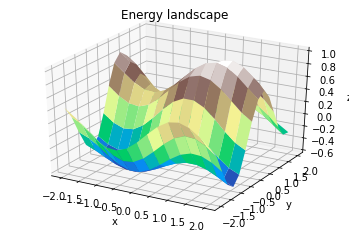

In [45]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, z, cmap='terrain')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Energy landscape')
plt.show()

-0.05162879193368861 [-0.2857142857142858, -1.4285714285714286]


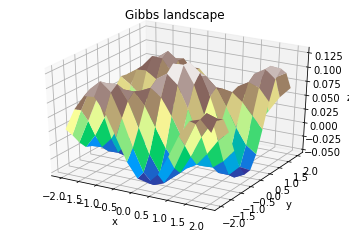

In [49]:
min_val=np.amin(z)
ind=np.unravel_index(np.argmin(z),z.shape)
coor=[X[ind[0],ind[0]],Y[ind[1],ind[1]]]

print(min_val,coor)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, z, cmap='terrain')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Gibbs landscape')
plt.show()

<ipython-input-51-5488ccec9ae9>:3: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  ax.plot_surface(X, Y, z, cmap='terrain')


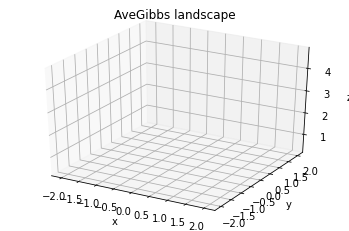

[[4.20468744        nan        nan 3.30936459 2.15246754 3.3650135
         nan        nan        nan        nan 1.37008643 0.84546769
  1.07723892 2.36669739        nan]
 [       nan        nan 1.30599908 0.85574497 1.38720924        nan
         nan        nan        nan 1.04899695 0.39760981 0.48879861
  1.3115045         nan        nan]
 [       nan 2.2564655  0.54478378 0.42774602 1.39579272        nan
         nan        nan 4.03384071 0.54822837 0.24987499 0.61524327
  2.33310722        nan        nan]
 [       nan 1.44387405 0.42898531 0.50718721 2.05826161        nan
         nan        nan 2.64187992 0.70975994 0.57814131 1.23676952
         nan        nan        nan]
 [       nan 1.51872747 0.88515581 1.21199907        nan        nan
         nan        nan        nan 1.92230771 1.81317192 4.17511855
         nan        nan        nan]
 [4.82430764 3.94181877        nan        nan        nan        nan
         nan        nan        nan        nan        nan        nan
     

In [51]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, z, cmap='terrain')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('AveGibbs landscape')
plt.show()
print(z)

### Nelder-Mead Simplex Algorithm

In [28]:
#Initializing simplex
#I am assuming Cartesian in matrix representation
def simplex_init(n,p,scale):
    #n is the number of simplex
    #p0 is the initial point
    
    x=scale*np.random.rand(n,2*p)
    return(x)

In [53]:
n=5
scale=5
x=simplex_init(n,2*p,scale)
f=np.zeros(n)
for i in range(n):
    f[i]=AveEnergy(x[i],*arg)
    print(x[i],f[i])
    


[0.92317108 1.79490746 4.38256974 2.96171123] -0.19087035110822373
[4.44681982 4.37682233 2.61441466 4.05387   ] 0.2743614387770656
[2.88551502 1.933726   0.45733092 1.90168599] 0.40925075963260726
[4.06462033 4.67548563 1.17780632 0.67966867] -0.0016225551778136782
[2.59340427 2.56909118 4.10859877 0.71299045] 0.18726774271259786
